# Introduction

This notebook documents the training of a vanilla CNN model for the image inpainting task as a baseline.

As a baseline we implement a simple basic CNN model where all feature maps have the same shape as the input and output.

**1. Choice of metrics**

We have chosen four metrics to measure image quality, and will be maintaining this for all experiements. They are: 
* L1 loss, for its measurement of reconstruction pixel-wise accuracy
* L2 loss, for its detection of outlier pixel values
* Peak SnR, for its measurement of noise in the image 
* [Learned perceptual similarity (VGG)](https://richzhang.github.io/PerceptualSimilarity/), for its effectiveness in measuring perceptual similarity. 


**2. Choice of training parameters**

We have set the following training parameters: 

* Batch size of 32, for 20 epochs, to balance GPU memory constraints, epoch completition time vs. stochasticity in gradient descent, and model training time
* Initial learning rate of 0.001, with ADAM optimizer, for its [effectiveness](https://cs231n.github.io/neural-networks-3/)
* Learning rate schedule to halve learning rate after 3 epochs of no-improvement in validation loss


**3. Choice of loss function**

We chose L1 loss as a basic pixel-wise reconstruction loss for its simplicity and relative performance to L2 loss, which has shown to [generate blurry images](https://ieeexplore.ieee.org/document/7797130) and be susceptible to outlier values skewing the loss. 


# Initialization

## Imports

In [1]:
# functional
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import lpips
from sklearn.model_selection import train_test_split

# visualization
import matplotlib.pyplot as plt

# metrics
import torchmetrics

# wandb
import wandb

/home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import custom methods

In [2]:
import sys
sys.path.append("/home/e/e0425222/CS4243/")
from utils.dataset_utils.AnimalDataset import AnimalDataset
from utils.train_utils.train_utils import visualize_results, sample_batch, train_evaluate

# Model

In [3]:
class VanillaCNN(nn.Module):

    def __init__(self, 
                 layers = 10,
                 in_channels = 3, 
                 hidden_channels = 64, 
                 out_channels = 3, 
                 kernel_size = 3, 
                 stride = 1, 
                 padding = 'same',
                 activation = nn.ReLU):
        super(VanillaCNN, self).__init__()

        self.first = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, 
                      out_channels = hidden_channels, 
                      kernel_size = kernel_size, 
                      stride = stride, 
                      padding = padding), 
            nn.BatchNorm2d(hidden_channels),
            activation())
        
        self.middle = nn.ModuleList([nn.Sequential(
            nn.Conv2d(in_channels = hidden_channels, 
                      out_channels = hidden_channels, 
                      kernel_size = kernel_size, 
                      stride = stride, 
                      padding = padding), 
            nn.BatchNorm2d(hidden_channels),
            activation()) for i in range(layers)])
        
        self.last = nn.Conv2d(in_channels = hidden_channels, 
                               out_channels = out_channels, 
                               kernel_size = kernel_size, 
                               stride = stride, 
                               padding = padding)
        
    def forward(self, input_tensor):
        x = input_tensor
        x = self.first(x)
        for i, l in enumerate(self.middle):
            x = l(x) + x
        x = self.last(x)
        return x

    def summary(self, verbose = False):
        count = 0
        if verbose:
            print(self)

        for name, params in self.named_parameters():
            num_params = params.flatten().size()[0]
            count += num_params
            if verbose:
                print(f"\nlayer: {name}")
                print(f"number of params: {num_params}")
                print(f"params shape: {params.size()}")

        print(f"model has {count/1e6} million parameters")




## Initialize model
Note that there is a significant difference in the depth (and thus, number of parameters) in the model. There are equivalently 17 layers in this model, relative to the 10 in the original CNN model.

In [4]:
# model parameters
layers = 20
in_channels = 4
out_channels = 3
hidden_channels = 32
kernel_size = 3
stride = 1
padding = 'same'
activation = nn.PReLU

# create model
model = VanillaCNN(layers,
                   in_channels, 
                   hidden_channels, 
                   out_channels,
                   kernel_size, 
                   stride, 
                   padding,
                   activation)

model.summary(verbose = False)


model has 0.188376 million parameters


## Save model

In [5]:
MODEL_FOLDER = "/home/e/e0425222/CS4243/model_weights/VanillaCNN"

In [6]:
# save path
MODEL_NAME = "VanillaCNN_20layers_32hidden_prelu"
SAVE_PATH = f"{MODEL_FOLDER}/{MODEL_NAME}"

# save
torch.save(model.state_dict(), SAVE_PATH)

# sanity check
loaded = VanillaCNN(layers,
                    in_channels, 
                    hidden_channels, 
                    out_channels,
                    kernel_size, 
                    stride, 
                    padding,
                    activation)

loaded.load_state_dict(torch.load(SAVE_PATH))
loaded.summary()
del loaded

model has 0.188376 million parameters


# Training Details
For training, we define all details here, and wrap it into two main dictionaries, `training_params` and `metrics`.

## Custom loss function

In [7]:
def mask_segmented_loss(output, target, mask, loss_function = nn.functional.l1_loss):
    """
    This is a custom functional loss function that considers where the mask is, and
    applies the loss function seperately. 
    """
    
    LOSS = loss_function # can use l1 loss or coarse to fine refinement


    def weighted_sum():
        MASKED_WEIGHT = 1
        UNMASKED_WEIGHT = 0

        # weights by mask, unmasked as 1
        masked_weights = (mask - 1) * -1 * MASKED_WEIGHT # invert the mask in a differentiable way
        unmasked_weights = mask * UNMASKED_WEIGHT
        
        # weighted sum
        loss_masked = LOSS(output, target, reduction = 'none')
        loss_unmasked = LOSS(output, target, reduction = 'none')
        loss = torch.mul(loss_masked, masked_weights) + torch.mul(loss_unmasked, unmasked_weights)
        loss = torch.mean(loss)
        return loss

    loss = weighted_sum()

    return loss


## Training parameters


In [8]:
# device
parallel = True
device = 'cuda:2'  
devices = [2, 3]

if not parallel:
    model = model.to(device)
else:
    model = nn.DataParallel(model, device_ids = devices)

In [9]:
# define training parameters
num_epochs = 20
batch_size = 32

# optimizer parameters
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

# loss function 
loss_function = mask_segmented_loss

# wrap into dictionary
training_params = {
    "num_epochs" : num_epochs,
    "batch_size" : batch_size, 
    "learning_rate": learning_rate,
    "optimizer" : optimizer,
    "scheduler" : scheduler,
    "schedule_every" : 1,
    "loss_function" : loss_function,
    "save_path" : SAVE_PATH
}



## Metrics

In [10]:
# instantiate metric objects if needed
VGG_LPIPS = lpips.LPIPS(net = 'vgg').to(device)

# define metrics
metrics = {
    "Peak SnR" : lambda img, gt, mask : torchmetrics.functional.peak_signal_noise_ratio(img * (-mask + 1), gt * (-mask + 1)),
    "L2 loss" : lambda img, gt, mask : nn.functional.mse_loss(img * (-mask + 1), gt * (-mask + 1)),
    "L1 loss" : lambda img, gt, mask : nn.functional.l1_loss(img * (-mask + 1), gt * (-mask + 1)),
    "learned perceptual image patch similarity" : (lambda img, gt, mask : VGG_LPIPS(img * (-mask + 1), gt * (-mask + 1)).mean())
}


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/lpips/weights/v0.1/vgg.pth


## Load Frogs dataset

In [11]:
dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243/dataset/frogs/frogs_wanted_indices_url.txt",
                        root_dir_path = "/home/e/e0425222/CS4243/dataset/frogs/images",
                        local_dir_path = "/home/e/e0425222/CS4243/dataset/frogs/preprocessed",
                        file_prefix = "frog_",
                        image_dimension = 128,
                        concat_mask = True)

dataset.initialize()

# train-test split
VALID_SIZE = 0.2
NUM_WORKERS = 2

indices = torch.arange(len(dataset))
train_indices, validation_indices = train_test_split(indices, test_size = VALID_SIZE)
train_dataset = Subset(dataset, train_indices)
validation_dataset = Subset(dataset, validation_indices)


Cleaning ...
Cleaning completed. Dropped 1 files. Took 0.8676512082417805 min
The row indices dropped were [3839]


## Logging

In [12]:
# training config file
config = {
    "model_name" : MODEL_NAME,
    "dataset_details" : {
        "img_dim" : 128,
        "indices_file" : "frogs_wanted_indices_url.txt",
        "random_crop" : True,
        "concat_mask" : True
    },
    "train" : {
        "num_epochs" : num_epochs,
        "batch_size" : batch_size, 
        "learning_rate": learning_rate,
        "optimizer" : "ADAM",
        "scheduler" : {
            "name" : "ReduceLROnPlateau",
            "params" : ['min', 0.5, 3, 1e-6]
        },
        "schedule_every" : 1,
        "loss_function" : {
            "description" : "masked loss, loss only applied to masked region",
            "loss_function" : "learned perceptual similarity (vgg)"
        },
    }
}

# wandb logging
wandb.init(project="VanillaCNN", entity="cs4243_project")
wandb.config = config


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tanyjnaaman (use `wandb login --relogin` to force relogin)


# Training

## Training

In [13]:
torch.autograd.set_detect_anomaly(True)

# train
running_train_results, running_eval_results = train_evaluate(model, device, train_dataset, validation_dataset, training_params, metrics)


===== Epoch: 1 ===== 

Training ...
375/375: Peak SnR: 27.989169479370116   L2 loss: 0.024330943264222395   L1 loss: 0.006303038160627087   learned perceptual image patch similarity: 0.02852662568787734   loss: 0.006303038160627087      
Evaluating ...
94/94: Peak SnR: 30.13308557550958   L2 loss: 0.000989836126694733   L1 loss: 0.003524122162761682   learned perceptual image patch similarity: 0.024338031801930133   loss: 0.003524122162761682       
Completed epoch 1! Took 6.337682096163432 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 2 ===== 

Training ...
375/375: Peak SnR: 30.3665796101888   L2 loss: 0.0009413943160325288   L1 loss: 0.0034551384560763836   learned perceptual image patch similarity: 0.022905642886956533   loss: 0.0034551384560763836     
Evaluating ...
94/94: Peak SnR: 30.82574686090997   L2 loss: 0.0008464124489654886   L1 loss: 0.003233111953917653   learned perceptual image patch similarity: 0.02259611566253799   loss: 0.003233111953917653       
Completed epoch 2! Took 6.394502878189087 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 3 ===== 

Training ...
375/375: Peak SnR: 31.1036828511556   L2 loss: 0.000793183690480267   L1 loss: 0.003127805390705665   learned perceptual image patch similarity: 0.02152838417390982   loss: 0.003127805390705665   37    
Evaluating ...
94/94: Peak SnR: 31.534662388740703   L2 loss: 0.000717048760518392   L1 loss: 0.002975229223437132   learned perceptual image patch similarity: 0.021193660617350264   loss: 0.002975229223437132      
Completed epoch 3! Took 6.343284523487091 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 4 ===== 

Training ...
375/375: Peak SnR: 31.65331495666504   L2 loss: 0.0007013325260486453   L1 loss: 0.0029152508626381557   learned perceptual image patch similarity: 0.020488676242530347   loss: 0.0029152508626381557    
Evaluating ...
94/94: Peak SnR: 32.299499288518376   L2 loss: 0.0006014336305521825   L1 loss: 0.0026421290438404265   learned perceptual image patch similarity: 0.019048012822787178   loss: 0.0026421290438404265   
Completed epoch 4! Took 6.347420501708984 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 5 ===== 

Training ...
375/375: Peak SnR: 32.005595087687176   L2 loss: 0.0006464723800309002   L1 loss: 0.002786360211049517   learned perceptual image patch similarity: 0.019754957854747773   loss: 0.002786360211049517     
Evaluating ...
94/94: Peak SnR: 32.79477784988728   L2 loss: 0.0005363161440943665   L1 loss: 0.0024637679093854224   learned perceptual image patch similarity: 0.017616033494631027   loss: 0.0024637679093854224    
Completed epoch 5! Took 6.374720112482707 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 6 ===== 

Training ...
375/375: Peak SnR: 32.691387349446615   L2 loss: 0.0005511833344741414   L1 loss: 0.002529882443137467   learned perceptual image patch similarity: 0.01850480163594087   loss: 0.002529882443137467      
Evaluating ...
94/94: Peak SnR: 32.85081455555368   L2 loss: 0.0005321928270240414   L1 loss: 0.0024710728965224105   learned perceptual image patch similarity: 0.01731828506045202   loss: 0.0024710728965224105     
Completed epoch 6! Took 6.4329991380373635 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 7 ===== 

Training ...
375/375: Peak SnR: 32.699049728393554   L2 loss: 0.0005488268507954975   L1 loss: 0.002529433373982708   learned perceptual image patch similarity: 0.018326912097632885   loss: 0.002529433373982708     
Evaluating ...
94/94: Peak SnR: 33.24846602500753   L2 loss: 0.0004847544190310378   L1 loss: 0.002329897820365001   learned perceptual image patch similarity: 0.01694594435591964   loss: 0.002329897820365001   56   
Completed epoch 7! Took 6.38722794453303 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 8 ===== 

Training ...
375/375: Peak SnR: 32.998263844807944   L2 loss: 0.0005150851736155649   L1 loss: 0.002415659142037233   learned perceptual image patch similarity: 0.017579519626994927   loss: 0.002415659142037233     
Evaluating ...
94/94: Peak SnR: 33.24295537015225   L2 loss: 0.00048185015181475817   L1 loss: 0.002323629759361056   learned perceptual image patch similarity: 0.016684427302568517   loss: 0.002323629759361056      
Completed epoch 8! Took 6.4059831658999125 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 9 ===== 

Training ...
375/375: Peak SnR: 33.157096654256186   L2 loss: 0.0004961216120670239   L1 loss: 0.0023564199587951104   learned perceptual image patch similarity: 0.017175848431885243   loss: 0.0023564199587951104   
Evaluating ...
94/94: Peak SnR: 33.19388115659673   L2 loss: 0.00049488404437533   L1 loss: 0.0023418941319563445   learned perceptual image patch similarity: 0.01681189274692789   loss: 0.0023418941319563445        
Completed epoch 9! Took 6.397602021694183 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 10 ===== 

Training ...
375/375: Peak SnR: 33.21802323913574   L2 loss: 0.0004901423791112999   L1 loss: 0.0023412627999981244   learned perceptual image patch similarity: 0.016966516954203446   loss: 0.0023412627999981244     
Evaluating ...
94/94: Peak SnR: 33.53773827248431   L2 loss: 0.0004562221469352656   L1 loss: 0.002239989666664537   learned perceptual image patch similarity: 0.015930155470491723   loss: 0.002239989666664537       
Completed epoch 10! Took 6.6072905421257015 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 11 ===== 

Training ...
375/375: Peak SnR: 33.35665222167969   L2 loss: 0.0004753449735386918   L1 loss: 0.0022976240689555802   learned perceptual image patch similarity: 0.016722396877904732   loss: 0.0022976240689555802     
Evaluating ...
94/94: Peak SnR: 33.58439796528918   L2 loss: 0.00045213679271561907   L1 loss: 0.0022019696795936437   learned perceptual image patch similarity: 0.016040351687672923   loss: 0.0022019696795936437    
Completed epoch 11! Took 6.7461162328720095 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 12 ===== 

Training ...
375/375: Peak SnR: 33.34137296549479   L2 loss: 0.00047532037824081876   L1 loss: 0.002289721683288614   learned perceptual image patch similarity: 0.016510028784473735   loss: 0.002289721683288614      
Evaluating ...
94/94: Peak SnR: 33.50621306642573   L2 loss: 0.00045655335750470456   L1 loss: 0.0022065472737093396   learned perceptual image patch similarity: 0.015693997340078685   loss: 0.0022065472737093396    
Completed epoch 12! Took 6.433999085426331 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 13 ===== 

Training ...
375/375: Peak SnR: 33.51060085550944   L2 loss: 0.00045669549979114284   L1 loss: 0.002233807963008682   learned perceptual image patch similarity: 0.016353405776123205   loss: 0.002233807963008682      
Evaluating ...
94/94: Peak SnR: 33.43792962013407   L2 loss: 0.00046742421406459936   L1 loss: 0.002283124033946227   learned perceptual image patch similarity: 0.01618204605666564   loss: 0.002283124033946227       
Completed epoch 13! Took 6.465567684173584 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 14 ===== 

Training ...
375/375: Peak SnR: 33.82450148010254   L2 loss: 0.0004277902161314463   L1 loss: 0.0021236519111941256   learned perceptual image patch similarity: 0.01570233338822921   loss: 0.0021236519111941256      
Evaluating ...
94/94: Peak SnR: 33.89174656157798   L2 loss: 0.0004176127602361103   L1 loss: 0.002077593714583348   learned perceptual image patch similarity: 0.015364482810601909   loss: 0.002077593714583348       
Completed epoch 14! Took 6.4743778546651205 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 15 ===== 

Training ...
196/375: Peak SnR: 33.783754397411734   L2 loss: 0.00042986739965866094   L1 loss: 0.0021179870705890034   learned perceptual image patch similarity: 0.015404179278875187   loss: 0.0021179870705890034   

wandb: Network error (ReadTimeout), entering retry loop.


375/375: Peak SnR: 33.86002308146159   L2 loss: 0.0004224929882911965   L1 loss: 0.0020974143302688996   learned perceptual image patch similarity: 0.015401938637097677   loss: 0.0020974143302688996     
Evaluating ...
94/94: Peak SnR: 33.81615849758716   L2 loss: 0.0004303370225627193   L1 loss: 0.002085668667705056   learned perceptual image patch similarity: 0.015140443326945   loss: 0.002085668667705056   277    
Completed epoch 15! Took 6.4150759220123295 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 16 ===== 

Training ...
375/375: Peak SnR: 33.93579618326823   L2 loss: 0.0004157282152057936   L1 loss: 0.0020752934807290635   learned perceptual image patch similarity: 0.0153617514098684   loss: 0.0020752934807290635       
Evaluating ...
94/94: Peak SnR: 33.780757863470846   L2 loss: 0.000428367113698264   L1 loss: 0.002118160327688414   learned perceptual image patch similarity: 0.014937209867020237   loss: 0.002118160327688414       
Completed epoch 16! Took 6.49296612739563 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 17 ===== 

Training ...
375/375: Peak SnR: 34.044557891845706   L2 loss: 0.00040481088066007944   L1 loss: 0.002027920236500601   learned perceptual image patch similarity: 0.015014072405795257   loss: 0.002027920236500601     
Evaluating ...
94/94: Peak SnR: 34.2019734889903   L2 loss: 0.00039026753275972254   L1 loss: 0.0019552695671433305   learned perceptual image patch similarity: 0.014761532914448292   loss: 0.0019552695671433305     
Completed epoch 17! Took 6.5865340312321985 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 18 ===== 

Training ...
375/375: Peak SnR: 34.02191722106934   L2 loss: 0.00040826600002280127   L1 loss: 0.0020398611997564636   learned perceptual image patch similarity: 0.015148130888740221   loss: 0.0020398611997564636    
Evaluating ...
94/94: Peak SnR: 34.012736746605405   L2 loss: 0.0004100814219279353   L1 loss: 0.002068474529647922   learned perceptual image patch similarity: 0.015019086902921504   loss: 0.002068474529647922      
Completed epoch 18! Took 6.490707373619079 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 19 ===== 

Training ...
375/375: Peak SnR: 34.059893417358396   L2 loss: 0.00040540949476417155   L1 loss: 0.0020261096839482586   learned perceptual image patch similarity: 0.015078363853196303   loss: 0.0020261096839482586   
Evaluating ...
94/94: Peak SnR: 33.98045422168488   L2 loss: 0.00041105231951966764   L1 loss: 0.002053272225547265   learned perceptual image patch similarity: 0.014961067557414161   loss: 0.002053272225547265      
Completed epoch 19! Took 6.427574030558268 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 20 ===== 

Training ...
375/375: Peak SnR: 34.22088260396322   L2 loss: 0.0003912058368635674   L1 loss: 0.0019630957546954353   learned perceptual image patch similarity: 0.01477902764827013   loss: 0.0019630957546954353      
Evaluating ...
94/94: Peak SnR: 34.361906700945916   L2 loss: 0.00037822994357718037   L1 loss: 0.0019049477847689327   learned perceptual image patch similarity: 0.014349840353540283   loss: 0.0019049477847689327   
Completed epoch 20! Took 6.531549561023712 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!


# Results and analysis

In [14]:
def visualize_results(model, device, running_train_results: dict, running_eval_results: dict, test_dataset = None, images_only = False):

    # get number of epochs and data points
    NUM_EPOCHS = len(list(running_train_results.values())[0])
    NUM_METRICS = len(list(running_train_results))
    assert list(running_train_results.keys()) == list(running_eval_results.keys())
    
    if not images_only:
        # plot 
        fig, ax = plt.subplots(NUM_METRICS, figsize = (NUM_EPOCHS * 5, NUM_METRICS * 5))
        epochs_axis = [i for i in range(NUM_EPOCHS)]
        index = 0
        for key in list(running_train_results.keys()):
            train = running_train_results[key]
            validation = running_eval_results[key]

            ax[index].plot(epochs_axis, train, label = "train")
            ax[index].plot(epochs_axis, validation, label = "validation")
            ax[index].title.set_text(key)
            index += 1

    if test_dataset != None:
        SAMPLE_SIZE = 8
        loader = DataLoader(test_dataset, batch_size = SAMPLE_SIZE, shuffle = True)
        batch = next(iter(loader))

        # predict
        model.eval()
        output = model(batch["image"].to(device).permute(0, 3, 1, 2)).detach().cpu().permute(0, 2, 3, 1)
        fig, ax = plt.subplots(3, SAMPLE_SIZE, figsize = (SAMPLE_SIZE * 5, 15, ))
        for i in range(SAMPLE_SIZE):
            image = batch["image"][i]
            reconstructed = batch["reconstructed"][i]
            predicted = output[i]

            if image.shape[-1] > 3: 
                image = image[:, :, 0:3] # take rgb if more than 3 channels
                
            ax[0][i].imshow(image)
            ax[1][i].imshow(reconstructed)
            ax[2][i].imshow(predicted)
            
        plt.show()
        plt.close()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


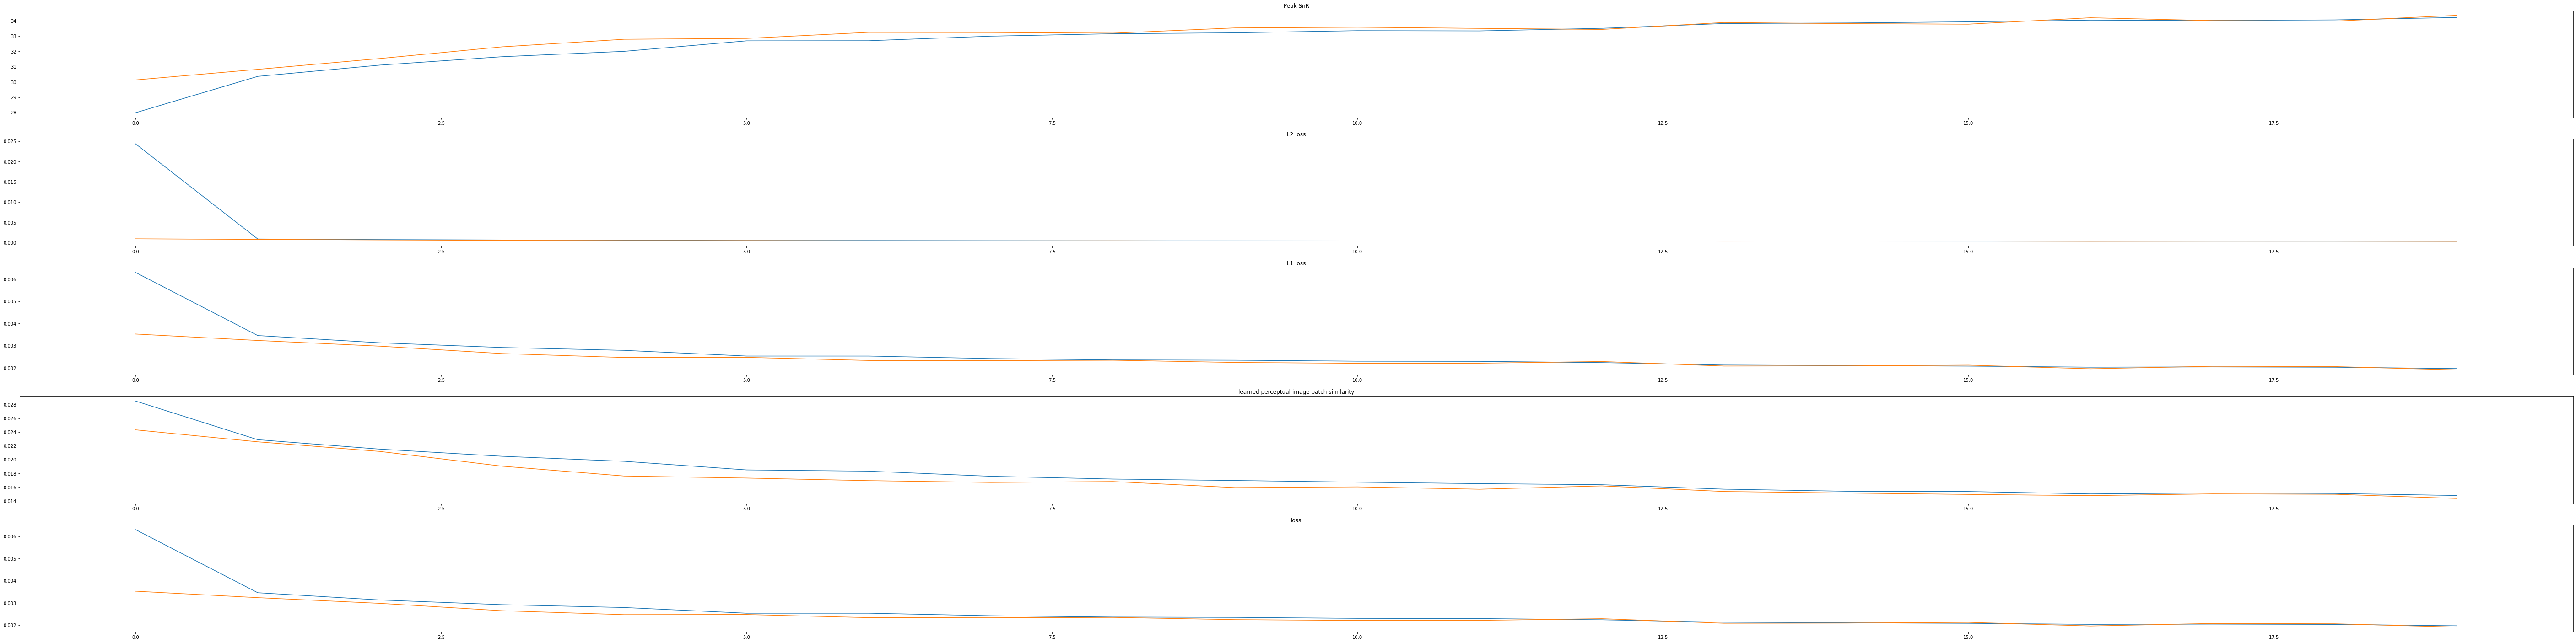

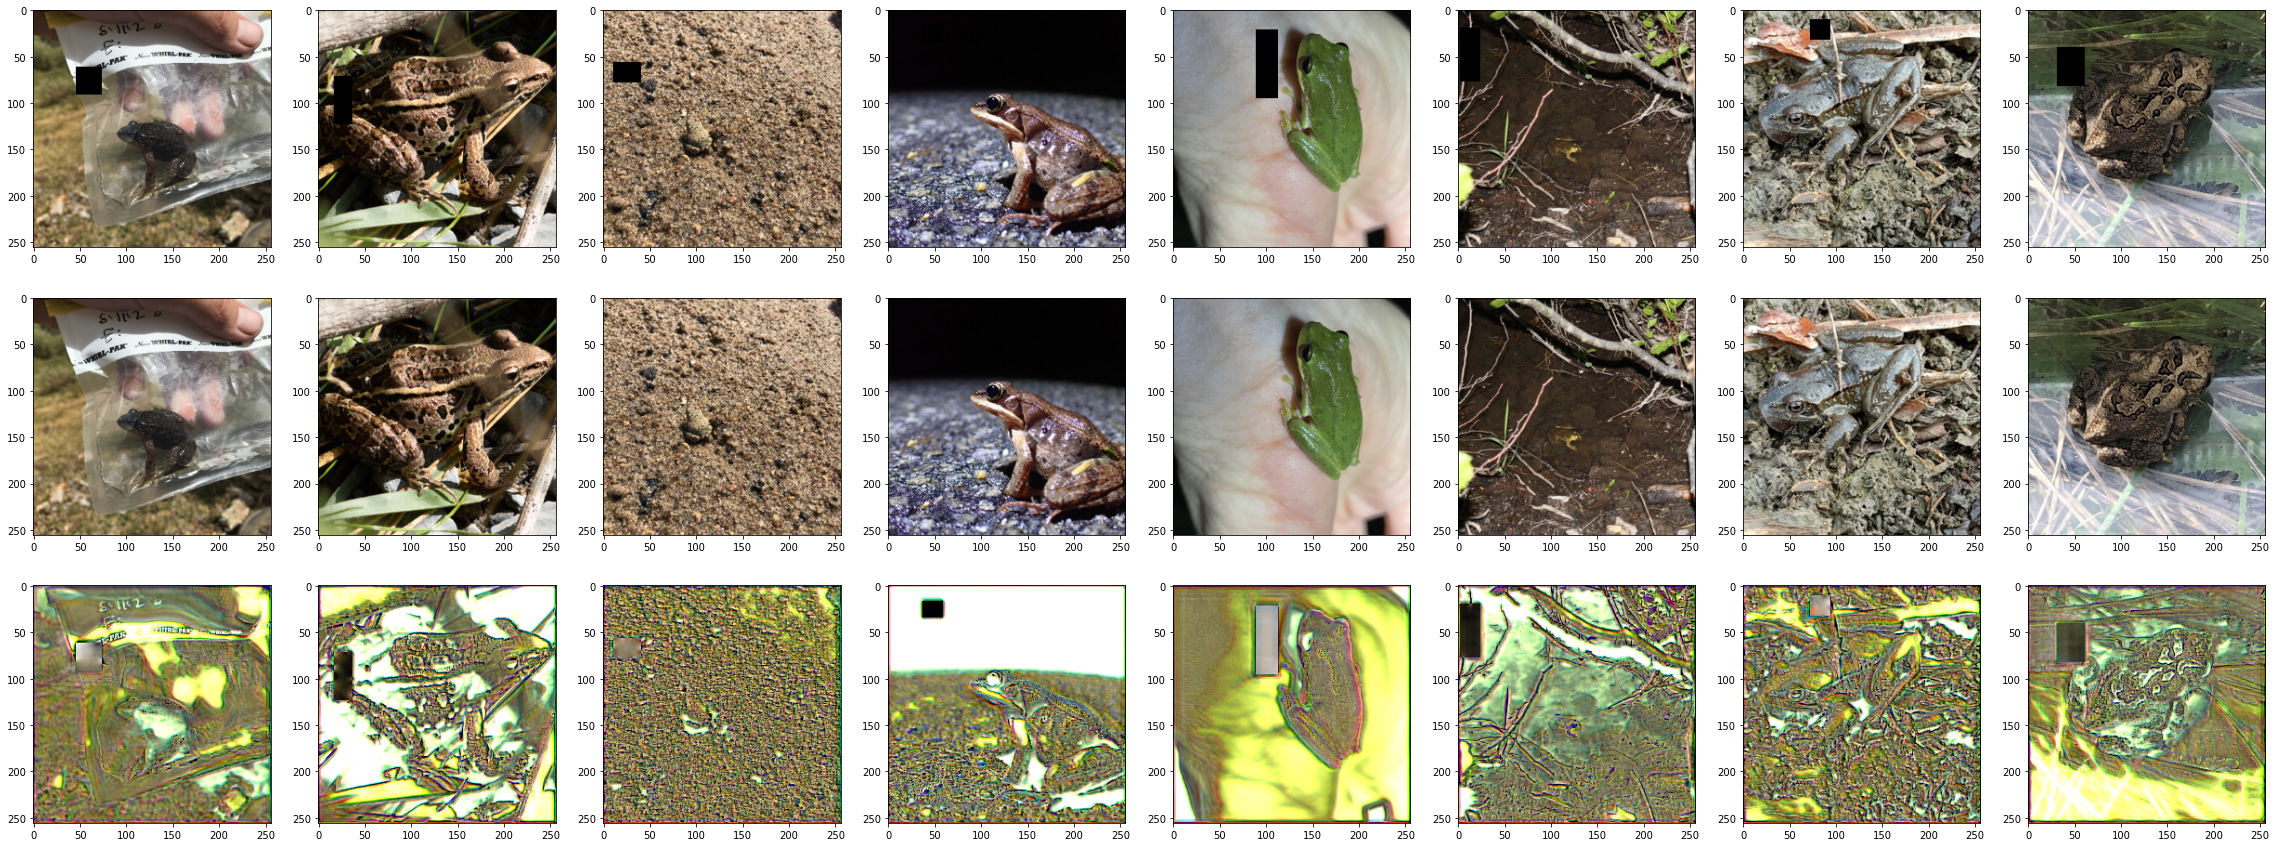

In [15]:
visualize_results(model, device, running_train_results, running_eval_results, test_dataset = validation_dataset)